# Calibrating your Detector for Energy Response

## Introduction

## Experimental Set up

| Experimental Item | Description |
| -------- | ------- |
| Detectors | 2x Scionix 38 B 37 1.5M - E1 PMT |
| Detector Bias | 500 Volts (for both) |
| Source Type | Spectrum Techniques Cs137 |
| Source Activity | 5 uCi |
| Source Manufacture Date | May 2017 |
| Source Half Life | 30.1 yrs |
| Cables | 50 Ohm LEMO - 10ns length |
| Vireo Input Termination | 50 Ohm |

*add picture of setup*

*add Diagram of setup*

### Calibrating your Detector for Energy Response (Cs137)



### Setting up Environment

We're going to define some variables up front so they are easier to change later. `TRIGGER_SENSITIVITY` defines how sensitive the trigger is to capture a pulse. `NUMBER_OF_EVENTS` indicates how many events we are going to capture before stopping data collection

___

## Collecting Data

In [1]:
%matplotlib inline
import skutils
import math
import numpy as np
import matplotlib.pyplot as plt
import scipy

plt.rcParams["figure.figsize"] = [20, 9]

# VIREO_URL = "192.168.128.154"
VIREO_URL = "vireo-000019.tek"
# VIREO_URL = "192.168.7.2"         # USB IP address by default if using USB - This does not change
TRIGGER_SENSITIVITY = 5
NUMBER_OF_EVENTS = 10_000
EXPERIMENT_NAME = "Cs137_Energy_Calibration"

Skutils is in beta, please contact support@skutek.com with bugs, issues, and questions


### 1) Connect to your FemtoDAQ Vireo

We can use the `FemtoDAQController` class to control our digitizer remotely in this python script. The FemtoDAQ Controller contains functions to control trigger, data capture, and recording configuration. We will use it here to configure our trigger parameters.

In [ ]:
vireo = skutils.FemtoDAQController(VIREO_URL)
print(vireo.summary())

### 3) Configure Data Recording Parameters

Before capturing data, we need to configure the instrument to trigger at the appropriate level 


{{EXPERIMENT_NAME}}

In [3]:
# load default trigger settings so we know that we're starting changing settings from a known parameter set
vireo.loadDefaultConfig()

# Configuring Trigger Settings
vireo.setTriggerSensitivity(0, TRIGGER_SENSITIVITY)
vireo.setTriggerSensitivity(1, TRIGGER_SENSITIVITY)
vireo.setTriggerXPosition(128)
vireo.setInvertADCSignal(0, True)
vireo.setInvertADCSignal(1, True)
vireo.setTriggerAveragingWindow(0, 16)
vireo.setTriggerAveragingWindow(1, 16)
# Bring baseline to roughly zero - these number will vary depending on your unit.
vireo.setDigitalOffset(0, 660)
vireo.setDigitalOffset(1, 660)

vireo.setHistogramScaling(0, 1)
vireo.setHistogramScaling(1, 1)

# Enabling Triggers
vireo.setEnableTrigger(0, True)
vireo.setEnableTrigger(1, True)

# Configuring Pulse Windows
vireo.setPulseHeightAveragingWindow(8)
vireo.setTriggerActiveWindow(32)
vireo.setPulseHeightWindow(32)

### Collecting Data without Coincidence Filtering

In [4]:
# Configure Recording on CH0, CH1
vireo.configureRecording(
    channels_to_record=[0, 1],
    number_of_samples_to_capture=512,
    file_recording_name_prefix=EXPERIMENT_NAME,
    file_recording_format="igorph",
    file_recording_data_output="pulse_summaries",
    only_record_triggered=True,
)

# Configuring Coincidence
vireo.configureCoincidence("multiplicity", 1)

#### Start Waveform Capture

In [5]:
vireo.clearTimestamp()
vireo.start(NUMBER_OF_EVENTS)
# Wait for data to be collected up to a maximum of 5 minutes
timed_out = vireo.waitUntil(nevents=NUMBER_OF_EVENTS, timeout_time=300, print_status=True)
vireo.stop()

Vireo-000019 (http://vireo-000019.tek): collected 6753 out of 10000 events (67.5% complete) events. running time: 2.0sec
Vireo-000019 (http://vireo-000019.tek): collected 6753 out of 10000 events (67.5% complete) events. running time: 2.8sec
Vireo-000019 (http://vireo-000019.tek): collected 9999 out of 10000 events (100.0% complete) events. running time: 3.8sec
Vireo-000019 (http://vireo-000019.tek): Data Collection Complete


### 4) Download Data Files for Later Analysis

In [6]:
files = vireo.downloadLastRunDataFiles()

Vireo-000019 (http://vireo-000019.tek) Controller : downloaded `Cs137_Energy_Calibration_03.56.54PM_Apr23_2025_seq000001.itx` to '/home/skutek/app-notes/skutils-app-notes/Experiments/Cs137_Energy_Calibration/Cs137_Energy_Calibration_03.56.54PM_Apr23_2025_seq000001.itx'


### 5) Grab Pulse Heights from all events

First we are going to grab the pulse heights calculated by our firmware DSP. 

In [ ]:
# Skutils loader to display histogram from downloaded files
pulse_heights = []
ch0_ph = []
ch1_ph = []
for filename in files:
    loader = skutils.IGORPulseHeightLoader(filename)
    # loader = skutils.GretinaLoaderme)
    for chan_data in loader.channelByChannel():
        if chan_data.channel == 0:
            ch0_ph.append(chan_data.pulse_height)
        elif chan_data.channel == 1:
            ch1_ph.append(chan_data.pulse_height)

pulse_heights = np.asarray(pulse_heights)

### 6) Calculate a histogram using Numpy

In [28]:
bin_width = 4
bin_edges = np.arange(0, 2000, bin_width)
hist_bins = (bin_edges[:-1] + bin_edges[1:]) / 2
hist0, edges0 = np.histogram(
    ch0_ph,
    bins=bin_edges,
)  # range=(hist_bins.min(), hist_bins.max()))
hist1, edges1 = np.histogram(
    ch1_ph,
    bins=bin_edges,
)  # range=(hist_bins.min(), hist_bins.max()))

9989
9819


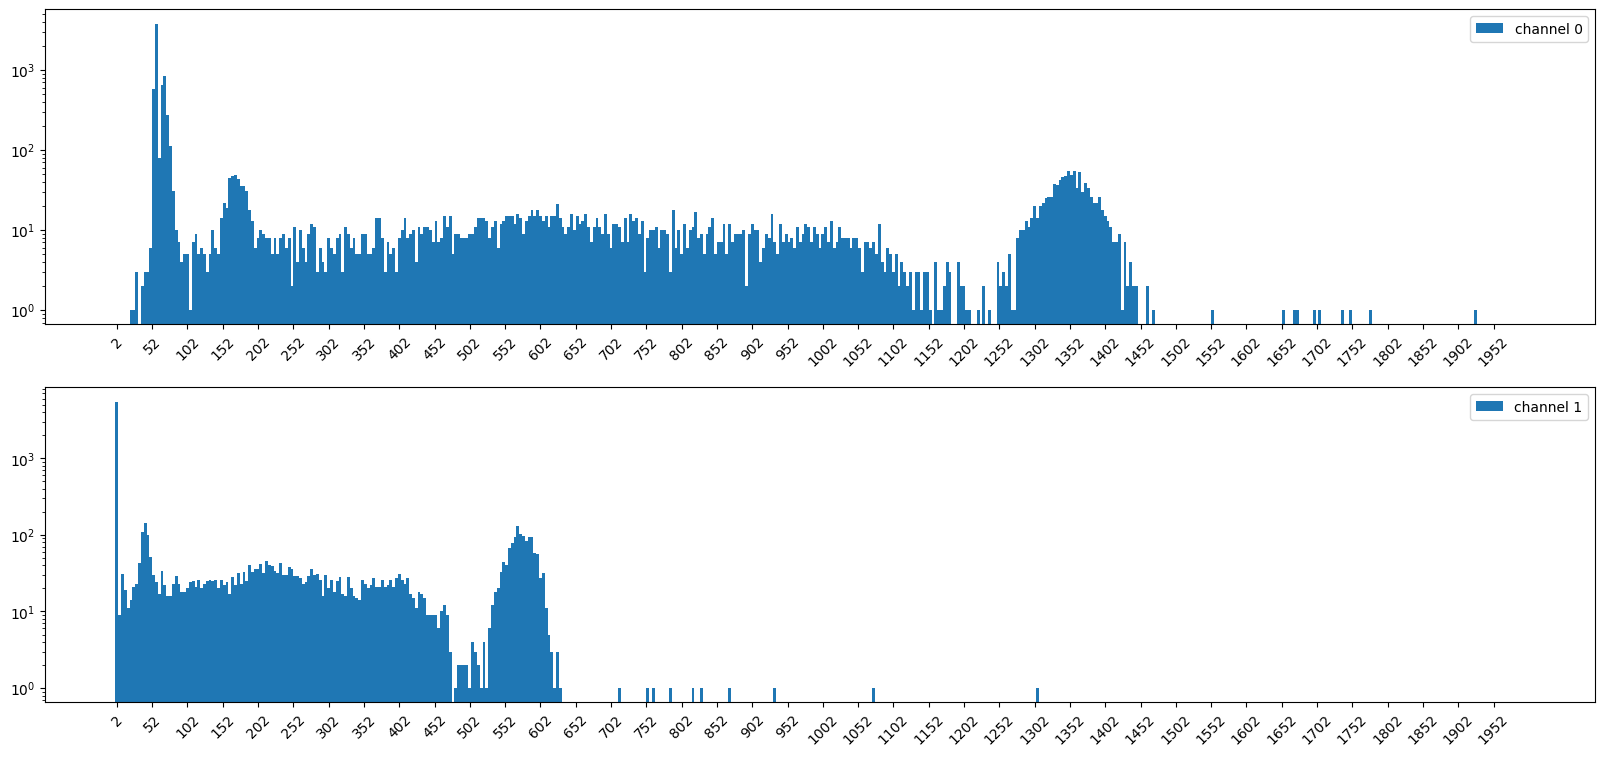

In [40]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 1)
axes[0].bar(hist_bins, hist0, width=bin_width, label="channel 0")
axes[1].bar(hist_bins, hist1, width=bin_width, label="channel 1")
axes[0].set_yscale("log")
axes[1].set_yscale("log")

axes[0].set_xticks(np.arange(hist_bins.min(), hist_bins.max(), step=50))
axes[1].set_xticks(np.arange(hist_bins.min(), hist_bins.max(), step=50))
axes[0].tick_params(axis="x", labelrotation=45)
axes[1].tick_params(axis="x", labelrotation=45)

print(np.sum(hist0))
print(np.sum(hist1))
axes[0].legend()
axes[1].legend()
plt.show()

#### A) Define the Noise peaks by hand 
#### $\color{red}{\textbf{Requires User Input}}$

In [1]:
noise_peak_cutoff_ch0 = 104
noise_peak_cutoff_ch1 = 12

SyntaxError: invalid syntax (1366605978.py, line 5)

9989
9819


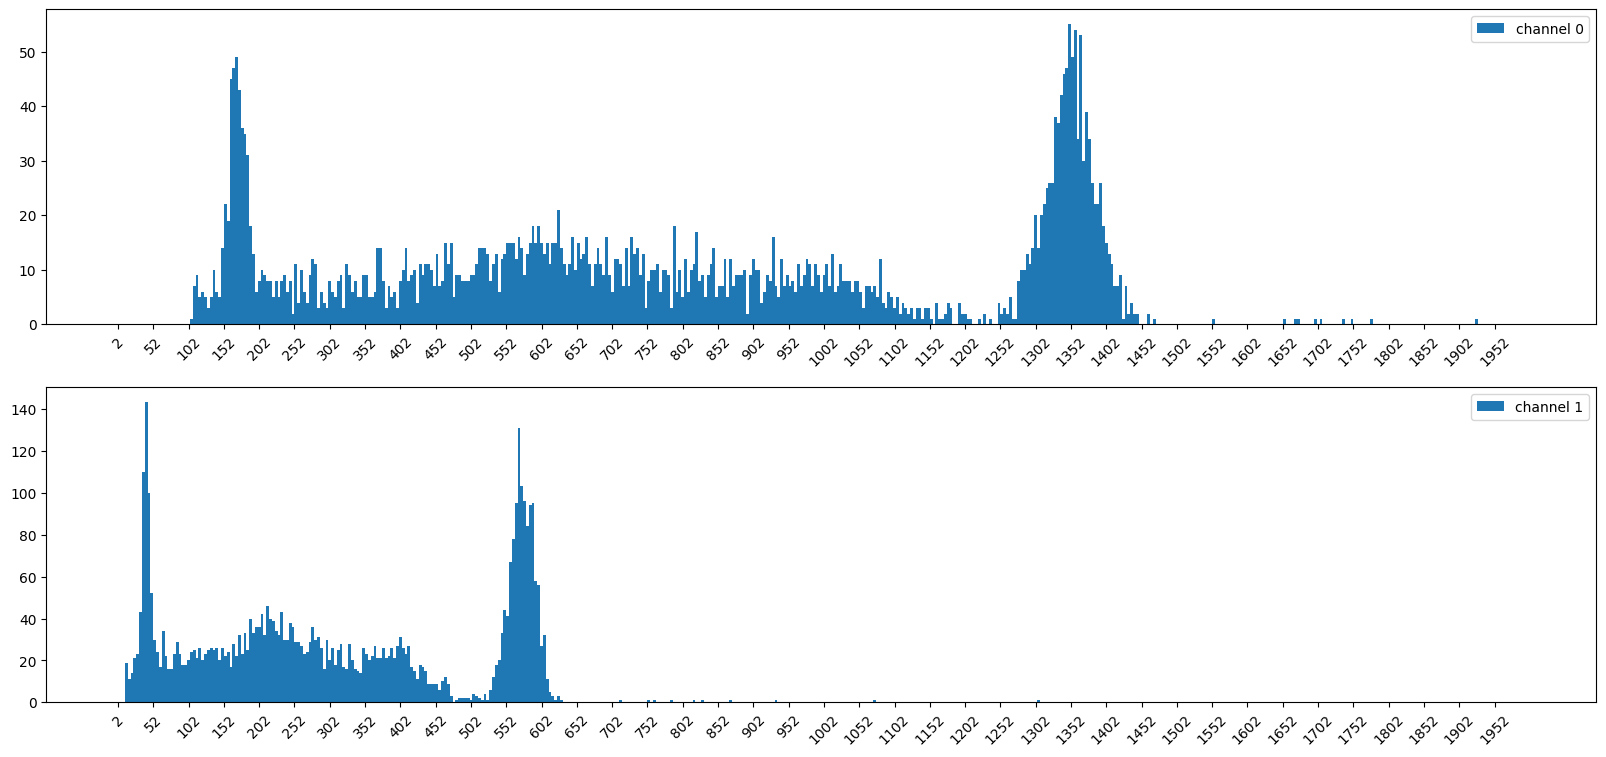

In [62]:
cutoff_bin_ch0 = noise_peak_cutoff_ch0 // bin_width
cutoff_bin_ch1 = noise_peak_cutoff_ch1 // bin_width

cutoff_hist0 = hist0.copy()
cutoff_hist0[:cutoff_bin_ch0] = 0

cutoff_hist1 = hist1.copy()
cutoff_hist1[:cutoff_bin_ch1] = 0


fig, axes = plt.subplots(2, 1)
axes[0].bar(hist_bins, cutoff_hist0, width=bin_width, label="channel 0")
axes[1].bar(hist_bins, cutoff_hist1, width=bin_width, label="channel 1")
# axes[0].set_yscale('log')
# axes[1].set_yscale('log')

axes[0].set_xticks(np.arange(hist_bins.min(), hist_bins.max(), step=50))
axes[1].set_xticks(np.arange(hist_bins.min(), hist_bins.max(), step=50))
axes[0].tick_params(axis="x", labelrotation=45)
axes[1].tick_params(axis="x", labelrotation=45)

print(np.sum(hist0))
print(np.sum(hist1))
axes[0].legend()
axes[1].legend()
# plt.show()

### 7) Finding our spectral peaks

mention the two peaks of Cs137


#### A) Define a two gaussian fitting function

**Add More**

In [63]:
def gaussian(hist_bins, amplitude, mean, sigma):
    result = amplitude / (sigma * 2 * np.pi) * np.exp(-0.5) * ((hist_bins - mean) / sigma) ** 2
    return result


def two_gaussians(
    hist_bins,  # raw channel histogram
    amplitudeA,
    meanA,
    sigmaA,  # fitting parameters for our first gaussian
    amplitudeB,
    meanB,
    sigmaB,  # fitting parameters for our second gaussian
):
    gaussianA = gaussian(hist_bins, amplitudeA, meanA, sigmaA)
    gaussianB = gaussian(hist_bins, amplitudeB, meanB, sigmaB)
    return gaussianA + gaussianB

#### A) Fit our histogram with two gaussians

**Add More**

In [64]:
ch0_2gauss_params, ch0_2gauss_covariance = scipy.optimize.curve_fit(two_gaussians, hist_bins, hist0, maxfev=100000)
ch1_2gauss_params, ch1_2gauss_covariance = scipy.optimize.curve_fit(two_gaussians, hist_bins, hist1, maxfev=100000)
ch0_2gauss_params

array([-1.36134454e-01,  2.69540747e+03,  1.38796595e+01, -3.08962083e+01,
        1.37838597e+03, -3.41140442e+01])

In [65]:
ch0_gaussA_amp, ch0_gaussA_mean, ch0_gaussA_sigma = ch0_2gauss_params[
    0:3
]  # grab the optimal parametets for one peak of ch0. amplitudeA, meanA, sigmaA
ch0_gaussB_amp, ch0_gaussB_mean, ch0_gaussB_sigma = ch0_2gauss_params[
    3:6
]  # grab the optimal parametets for the other peak of ch0. amplitudeB, meanB, sigmaB


ch0_gaussA = gaussian(hist_bins, ch0_gaussA_amp, ch0_gaussA_mean, ch0_gaussA_sigma)
ch0_gaussB = gaussian(hist_bins, ch0_gaussB_amp, ch0_gaussB_mean, ch0_gaussB_sigma)

9989
9819


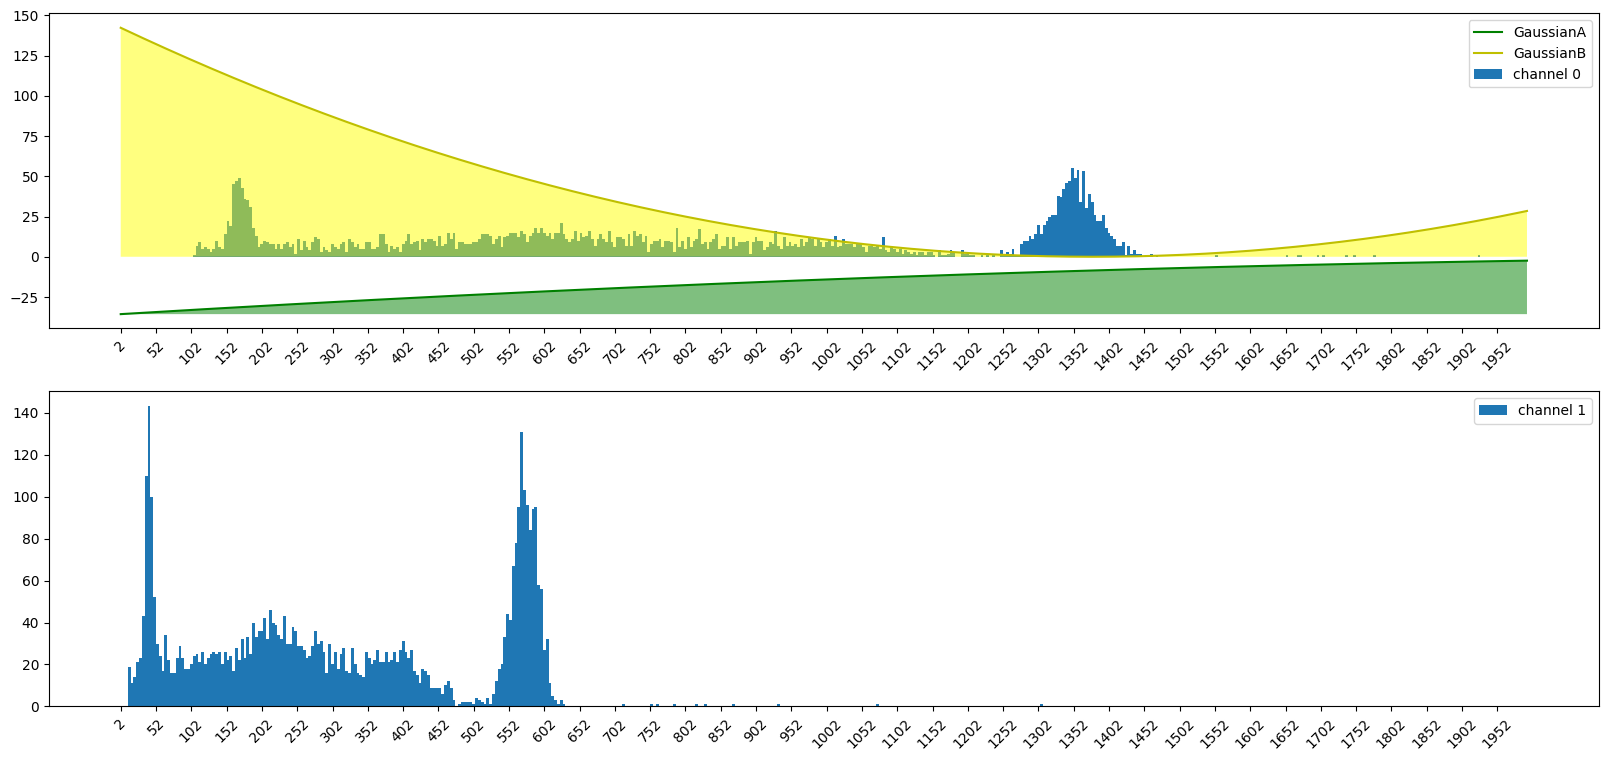

In [69]:
# fig,(ch0_ax,ch1_ax) = plt.subplots(2)
fig, axes = plt.subplots(2, 1)
axes[0].bar(hist_bins, cutoff_hist0, width=bin_width, label="channel 0")
axes[1].bar(hist_bins, cutoff_hist1, width=bin_width, label="channel 1")
# axes[0].set_yscale('log')
# axes[1].set_yscale('log')

axes[0].set_xticks(np.arange(hist_bins.min(), hist_bins.max(), step=50))
axes[1].set_xticks(np.arange(hist_bins.min(), hist_bins.max(), step=50))
axes[0].tick_params(axis="x", labelrotation=45)
axes[1].tick_params(axis="x", labelrotation=45)

print(np.sum(hist0))
print(np.sum(hist1))

axes[0].plot(hist_bins, ch0_gaussA, "g", label="GaussianA")
axes[0].fill_between(hist_bins, ch0_gaussA.min(), ch0_gaussA, facecolor="green", alpha=0.5)
axes[0].plot(hist_bins, ch0_gaussB, "y", label="GaussianB")
axes[0].fill_between(hist_bins, ch0_gaussB.min(), ch0_gaussB, facecolor="yellow", alpha=0.5)


axes[0].legend()
axes[1].legend()